<a href="https://colab.research.google.com/github/liberentaizp/Bioremediation-potential/blob/main/Bioremediation_potential_predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data loading**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
#Importing necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
from sklearn.decomposition import PCA
#!pip install scikit-bio
from skbio.stats.distance import permanova, DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import shap
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'left')

First we **load the data** and make sure we have uploaded it okay by seeing the first 5 rows. The data can be loaded directly from a drive directory.

In [4]:
data = '/content/drive/MyDrive/CIIMAR/Libe/BLAST 60 genomes/gene_counts_and_metadata.xlsx'
df = pd.read_excel(data, header=0, index_col=0, engine='openpyxl')
df.head()

,PobA,alkB,amoA,arsC,arsR1,bcsA,bcsB,BenR,bnzA,bphA1,bphA2,bphA3,bphA4,bphB,bphC,bphD,chR,copA,copA1,dmpK,dmpL,dmpM,dmpN,dmpO,dmpP,intl1,katA,merA,merB,merR,merT,mrdH,mreA,nahA1,nahA2,nahA3,nahA4,nahB,nahC,nahD,nahE,nahF,nirS,norB,oxyR,pcaG,pcaH,pcaR,rubA,sodA,srpA,srpB,srpC,srpR,srpS,tnpA,todA,todB,todC1,todC2,todD,todE,todF,todT,tolA,tolB,tolQ,tolR,ttgA,ttgB,ttgC,ttgD,ttgE,ttgF,ttgG,ttgH,ttgI,xylA,xylB,xylC,xylM,xylN,xylS,xylU,xylW,Isolation matrix,Specific isolation matrix,More specific,Host,Pollution,Localization,ST Cluster,Bioremediation potential
strain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12917,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,2,1,2,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,2,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Clinical,Rectal,No,Human,No,France,15,35
991_21,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,1,2,1,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Clinical,Respiratory,Trachea,Human,No,Brazil,7,31
ABACB,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,Rhizosphere,Agricultural soil,Kiwi,Plant,No,New zeland,19,18
AHSWHJXPP1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,Clinical,Urine,Lesion,Human,No,China,5,33
B001,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Soil,Sea,Sand,No,No,South Korea,12,23


# **Data cleaning and exploration**

## *Check missing values*



First of all we want to check for **missing values** that could hinder our analysis.

In [6]:
missing_values = df.isnull().sum()
if missing_values.any():
  print("Missing values found:")
  print(missing_values)
else:
  print("No missing values found.")

No missing values found.


Depending on the results of the missing values we will take different approaches. If we don't have missing values we can continue with the analysis.

If not, we should consider:

*   **Removing** rows or columns with missing values if they could be more misinforming than informing

```
df.dropna(inplace=True)  # Removes any rows with missing values

```

*   **Fill** missing values with specific value (mean, median...)

```
df.fillna(df.mean(), inplace=True)  # Replaces missing values with the column mean
```

*   **Forward or backward** filling, where we fill the missing values with the previous or posterior value in the column

```
df.fillna(method='ffill', inplace=True)  # Forward fill
df.fillna(method='bfill', inplace=True)  # Backward fill

```

*   Using **interpolation** to estimate missing values, estimating the missing data by creating a smooth curve or line through known points

```
df.interpolate(method='linear', inplace=True)  # Linear interpolation

```

## *Gene count subset*


For posterior analyses like clustering, we will need to only use the **gene count values**, so we will create a new dataset that will remove the categorical and bioremediation potential data called ***df_genecount***. For this we will have to write all the features that we want to drop from the df dataset.


In [26]:
df_genecount=df.drop(['Isolation matrix','Specific isolation matrix','More specific','Host','Pollution','Localization','ST Cluster','Bioremediation potential'], axis=1)
df_genecount.head()

,PobA,alkB,amoA,arsC,arsR1,bcsA,bcsB,BenR,bnzA,bphA1,bphA2,bphA3,bphA4,bphB,bphC,bphD,chR,copA,copA1,dmpK,dmpL,dmpM,dmpN,dmpO,dmpP,intl1,katA,merA,merB,merR,merT,mrdH,mreA,nahA1,nahA2,nahA3,nahA4,nahB,nahC,nahD,nahE,nahF,nirS,norB,oxyR,pcaG,pcaH,pcaR,rubA,sodA,srpA,srpB,srpC,srpR,srpS,tnpA,todA,todB,todC1,todC2,todD,todE,todF,todT,tolA,tolB,tolQ,tolR,ttgA,ttgB,ttgC,ttgD,ttgE,ttgF,ttgG,ttgH,ttgI,xylA,xylB,xylC,xylM,xylN,xylS,xylU,xylW
strain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12917,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,2,1,2,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,2,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
991_21,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,1,2,1,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
ABACB,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0
AHSWHJXPP1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0
B001,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## *Standarization (scaling) of data*


Some of the downstream analysis methods will need **standarized data**, as they are sensitive to scale of features (like PCA).

Because of this, we will create another data frame called ***df_numeric_scaled*** where all the numeric features are standarized.

In [27]:
scaler = StandardScaler()
df_genecount_scaled = scaler.fit_transform(df_genecount)

When we scale our data using any scaled from sklearn (as StandardScaled), the output is a NumPy array rather than a pandas DataFrame.

In [28]:
print(type(df_genecount_scaled))

<class 'numpy.ndarray'>


However, as we want to visualize the scaled data using different plots, we should convert it back to a DataFrame for better manipulation.

In [29]:
df_genecount_scaled_df = pd.DataFrame(df_genecount_scaled, columns=df_genecount.columns)
print(type(df_genecount_scaled_df))
df_genecount_scaled_df.head()

<class 'pandas.core.frame.DataFrame'>


,PobA,alkB,amoA,arsC,arsR1,bcsA,bcsB,BenR,bnzA,bphA1,bphA2,bphA3,bphA4,bphB,bphC,bphD,chR,copA,copA1,dmpK,dmpL,dmpM,dmpN,dmpO,dmpP,intl1,katA,merA,merB,merR,merT,mrdH,mreA,nahA1,nahA2,nahA3,nahA4,nahB,nahC,nahD,nahE,nahF,nirS,norB,oxyR,pcaG,pcaH,pcaR,rubA,sodA,srpA,srpB,srpC,srpR,srpS,tnpA,todA,todB,todC1,todC2,todD,todE,todF,todT,tolA,tolB,tolQ,tolR,ttgA,ttgB,ttgC,ttgD,ttgE,ttgF,ttgG,ttgH,ttgI,xylA,xylB,xylC,xylM,xylN,xylS,xylU,xylW
0,-0.3669,0.505291,0.0,-0.231455,-0.505291,2.213594,1.712698,0.222277,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.3669,0.658808,-0.131306,-0.231455,-0.26968,-0.231455,-0.396059,-0.26968,-0.26968,0.648919,0.269680,2.389144,4.320494,2.562050,2.932777,-0.177394,-0.177394,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,0.287348,-0.131306,0.743392,0.231455,0.131306,0.0,2.680215,0.505291,-0.30429,-0.421332,-0.336463,-0.30429,-0.336463,0.903268,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,0.0,0.0,-0.803530,0.0,0.0,0.954427,-0.131306,-0.187317,-0.495663,-0.26968,-0.30429,-0.421332,-0.336463,-0.131306,-0.131306,-0.131306,-0.131306,-0.131306,-0.177394,-0.187317,-0.131306
1,-0.3669,-1.979057,0.0,-0.231455,-0.505291,-0.451754,1.712698,0.222277,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.3669,-0.895979,-0.131306,-0.231455,-0.26968,-0.231455,-0.396059,-0.26968,-0.26968,3.594015,0.269680,0.889575,-0.231455,0.987457,-0.493636,-0.177394,-0.177394,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-2.538240,-0.131306,-1.345185,0.231455,0.131306,0.0,-0.720488,0.505291,-0.30429,-0.421332,-0.336463,-0.30429,-0.336463,2.383623,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,0.0,0.0,1.092801,0.0,0.0,0.954427,-0.131306,-0.187317,1.332093,-0.26968,-0.30429,-0.421332,-0.336463,-0.131306,-0.131306,-0.131306,-0.131306,-0.131306,-0.177394,-0.187317,-0.131306
2,-0.3669,-1.979057,0.0,-0.231455,-0.505291,2.213594,-0.583874,-2.400593,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.3669,-0.895979,-0.131306,-0.231455,-0.26968,-0.231455,-0.396059,-0.26968,-0.26968,-0.332779,-3.708099,-0.609994,-0.231455,-0.587137,-0.493636,-0.177394,-0.177394,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-2.538240,-0.131306,0.743392,0.231455,0.131306,0.0,-0.720488,0.505291,-0.30429,-0.421332,-0.336463,-0.30429,-0.336463,-0.577088,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,0.0,0.0,-0.803530,0.0,0.0,0.954427,-0.131306,-0.187317,3.159849,-0.26968,-0.30429,-0.421332,-0.336463,-0.131306,-0.131306,-0.131306,-0.131306,-0.131306,-0.177394,-0.187317,-0.131306
3,-0.3669,0.505291,0.0,-0.231455,-0.505291,-0.451754,-0.583874,0.222277,5.338539,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.3669,-0.895979,-0.131306,-0.231455,-0.26968,-0.231455,-0.396059,-0.26968,-0.26968,1.630618,0.269680,-0.609994,-0.231455,-0.587137,-0.493636,-0.177394,-0.177394,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,0.287348,-0.131306,0.743392,0.231455,0.131306,0.0,-0.720488,0.505291,-0.30429,-0.421332,-0.336463,-0.30429,-0.336463,-0.083636,5.338539,5.338539,5.338539,5.338539,5.338539,5.338539,5.338539,5.338539,0.0,0.0,-0.803530,0.0,0.0,-0.922613,-0.131306,5.338539,3.159849,-0.26968,-0.30429,-0.421332,-0.336463,-0.131306,-0.131306,-0.131306,-0.131306,-0.131306,-0.177394,-0.187317,-0.131306
4,-0.3669,0.505291,0.0,-0.231455,1.979057,-0.451754,-0.583874,0.222277,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.3669,-0.895979,7.615773,-0.231455,-0.26968,-0.231455,2.524876,-0.26968,-0.26968,-0.332779,0.269680,-0.609994,-0.231455,-0.587137,-0.493636,-0.177394,-0.177394,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.187317,-0.18731

## *Correlation analysis*

The next step is to assess relationships between features. Are they correlated? Does one feature influence another?

A **correlation analysis** reveals linear relationships, helping us identify redundant features (those that convey similar information). When features are highly correlated, we can choose to keep both, remove one, or combine them into a new, more informative feature. This simplifies the data, avoids overfitting and improves model performance.


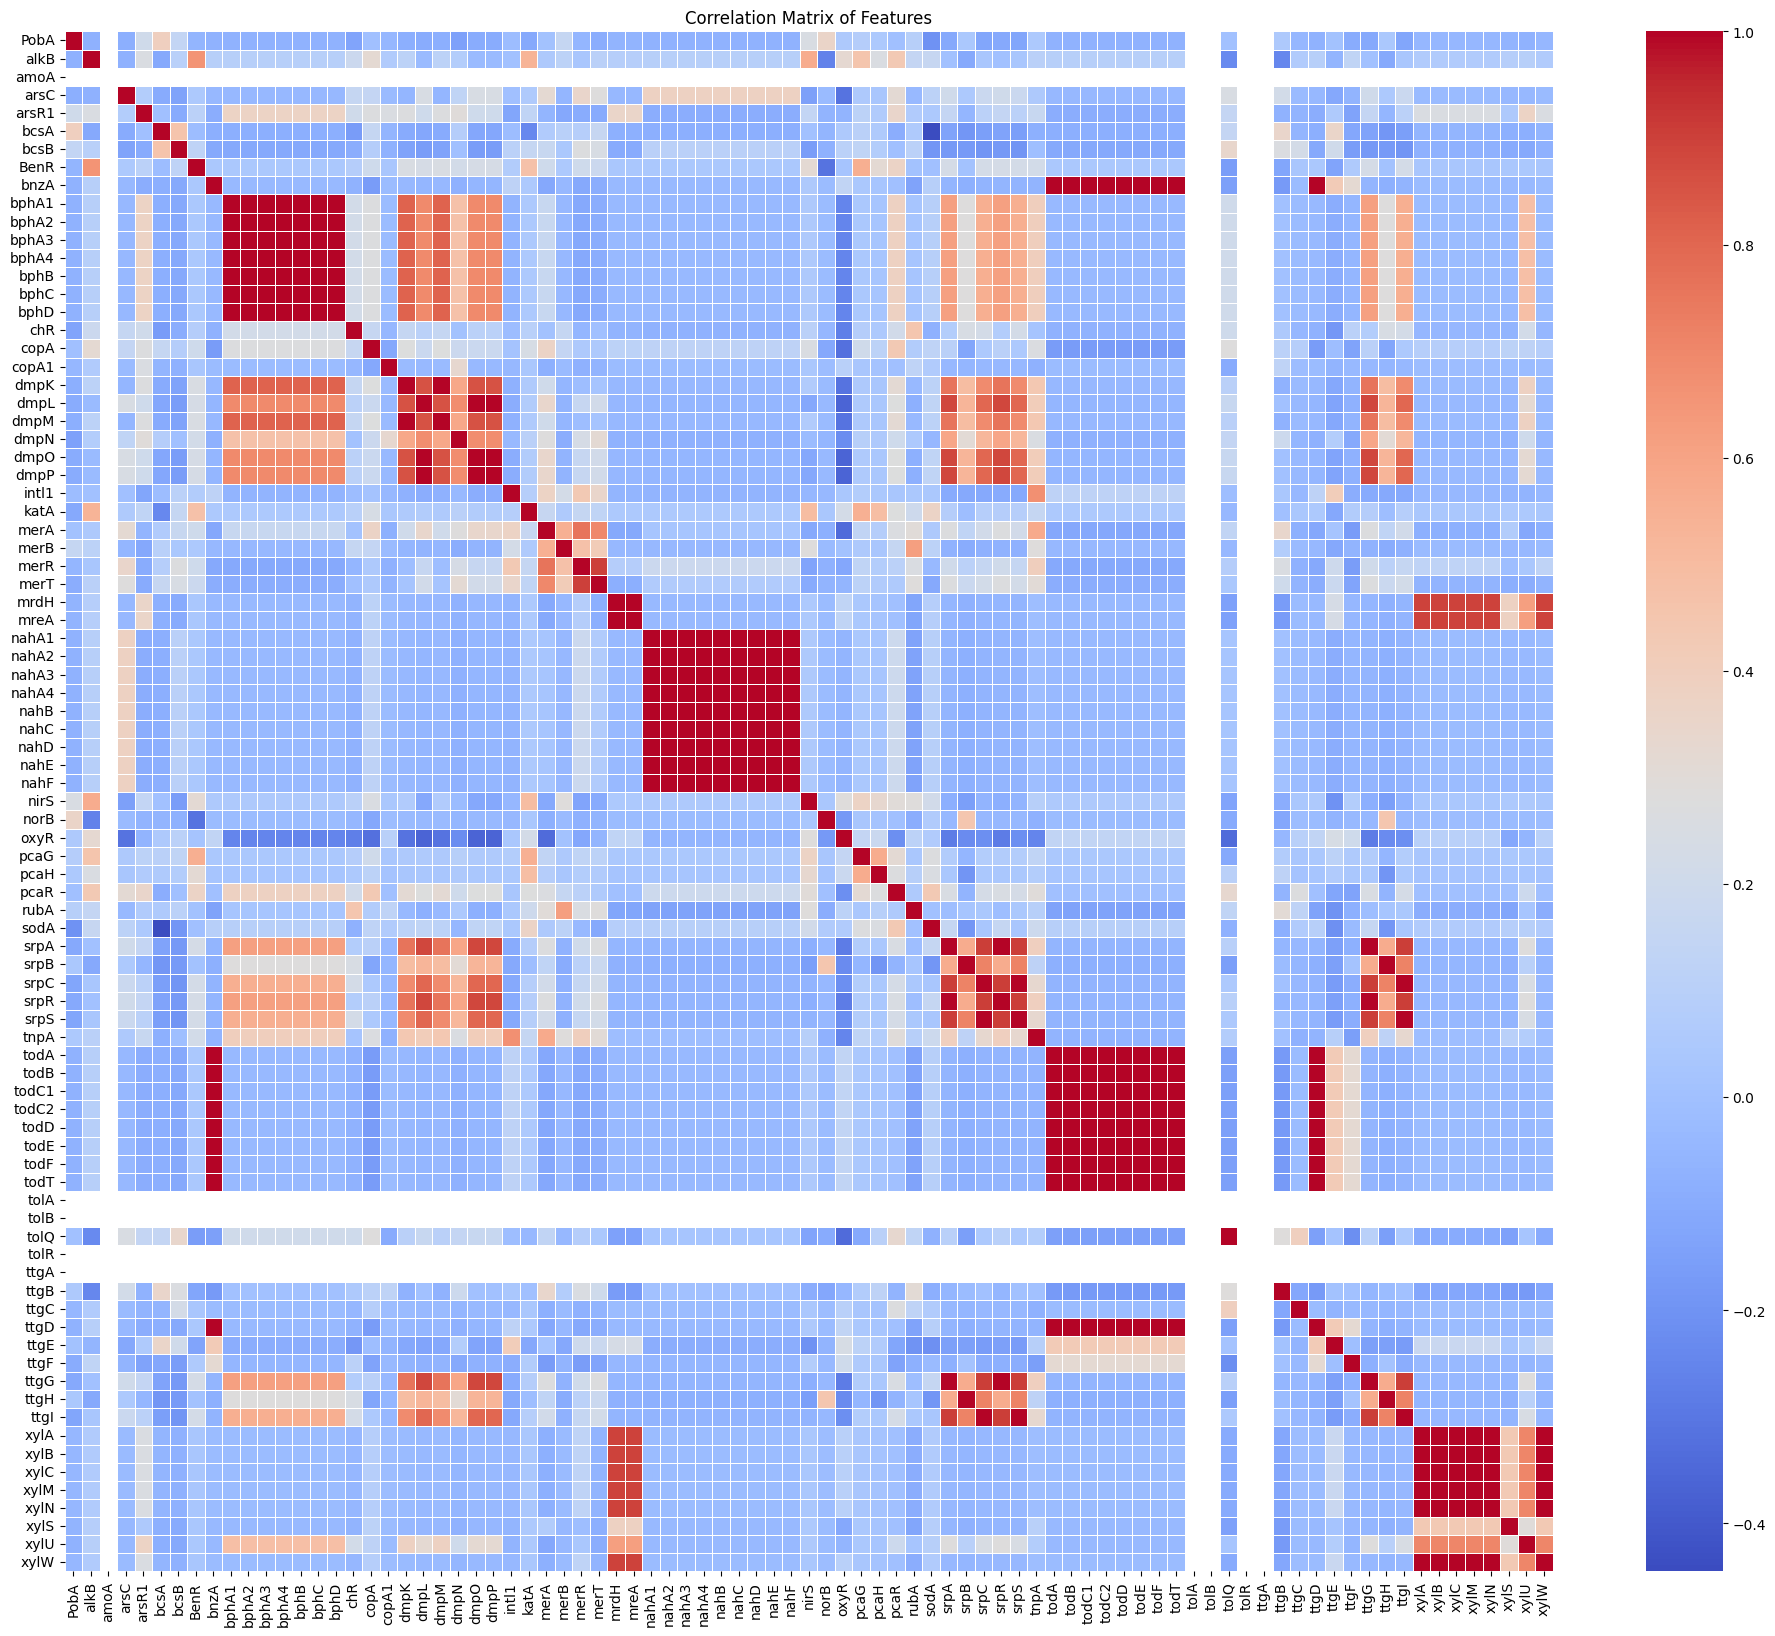

In [30]:
correlation_matrix = df_genecount.corr(method='pearson')
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, vmin=None, vmax=None, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

We see that the genes that are part of a same gene cluster (for example xylA, xylB, xylC...) are closely correlated, and that the presence of one of them implies the presence of others. This is biologically evident.
We could join the information of genes from a same cluster and form a new feature for each cluster. This would reduce the nosie, however, we will mantain all the genes as not all the clusters always contain all the present genes.

We can also see that some genes do not give any correlation information, as amoA, tolA, tolB, tolR and ttgA. This happens because the genes are present in all the genomes, so they do not give us any information. We will remove them from the dataset.

In [31]:
print('Number of genes counted before cleaning: ',str(len(df_genecount.columns)))
df_genecount.drop(['amoA', 'tolA', 'tolB', 'tolR', 'ttgA'], axis=1, inplace=True)
df_genecount_scaled_df.drop(['amoA', 'tolA', 'tolB', 'tolR', 'ttgA'], axis=1, inplace=True)
print('Number of genes counted after cleaning: ', str(len(df_genecount.columns)))

Number of genes counted before cleaning:  85
Number of genes counted after cleaning:  80


# **Unsupervised learning**

## *PCA*

Unsupervised learning consists on giving unlabeled data to a model and seeing how it organizes the data depending on the hidden patterns that it discovers.
In our case we will perform a **Principal Component Analysis (PCA)** in our numerical data (df_genecount).

In order to perform the PCA we will need to use our standarized data (df_genecount_scaled_df).

In [32]:
#We run PCA on scaled gene counts
pca = PCA(n_components=2)
df_genecount_pca = pca.fit_transform(df_genecount_scaled_df)

<ipython-input-41-ef774e8a50b9>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_genecount_pca[:, 0], df_genecount_pca[:, 1], cmap='viridis')


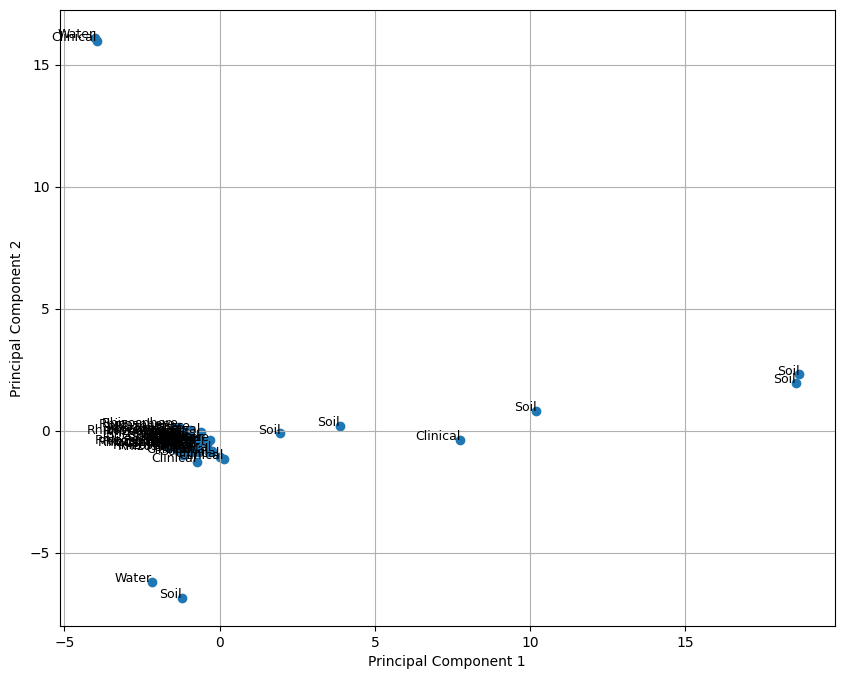

In [41]:
#We Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(df_genecount_pca[:, 0], df_genecount_pca[:, 1], cmap='viridis')
#We will now add the data labels (we can later replace the data labels with any feature)
for i, name in enumerate(df['Isolation matrix']):  # assuming `df_numeric` has row indices as names
    plt.text(df_genecount_pca[i, 0], df_genecount_pca[i, 1], name, fontsize=9, ha='right')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [40]:
#Now we want to know the explained variance ratio (weights) in percentages
explained_variance_ratio = pca.explained_variance_ratio_ * 100
print("Explained variance ratio:", explained_variance_ratio)

Explained variance ratio: [20.60958905 13.28137516]


In [42]:
#We will now determine the loadings for each feature in percentages
loadings_percent = pca.components_ * 100
feature_names = df_genecount_scaled_df.columns
loadings_df = pd.DataFrame(loadings_percent.T, index = feature_names, columns=['Component 1', 'Component 2'])
print("\nPrincipal components (loadings) with feature names:")
print(loadings_df)


Principal components (loadings) with feature names:
       Component 1  Component 2
PobA   -2.258526    -2.151272  
alkB    1.599544     2.602691  
arsC    3.113196    -6.079783  
arsR1   7.618194    -0.253456  
bcsA   -3.141297    -2.981396  
bcsB   -3.727311    -5.955186  
BenR    5.002463     1.623480  
bnzA   -4.535066    28.283743  
bphA1  21.144727     3.752705  
bphA2  21.144727     3.752705  
bphA3  21.144727     3.752705  
bphA4  21.144727     3.752705  
bphB   21.144727     3.752705  
bphC   21.144727     3.752705  
bphD   21.144727     3.752705  
chR     5.915257    -0.663906  
copA    6.444969    -5.847527  
copA1  -0.523646    -0.445225  
dmpK   22.192567     3.676290  
dmpL   22.561616     2.982043  
dmpM   22.192567     3.676290  
dmpN   15.881378     1.122154  
dmpO   22.561616     2.982043  
dmpP   22.561616     2.982043  
intl1  -1.903380     3.478744  
katA    2.489698     1.379548  
merA    7.869445    -4.261253  
merB   -0.659658    -2.356562  
merR    2.682592   

We can see that the PCA grouped almost all the strains together and some strains are spread across the graph. We have labeled the points that are spread across the graph depending on their source environment.
We can see that the strains that are grouped together mainly belong to strains that come from Rhizospheres, water and clinical samples.

In order to see if this has a relationship with the bioremediation potential we can also label the data with each corresponding BP.

<ipython-input-44-c6903a915af7>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_genecount_pca[:, 0], df_genecount_pca[:, 1], cmap='viridis')


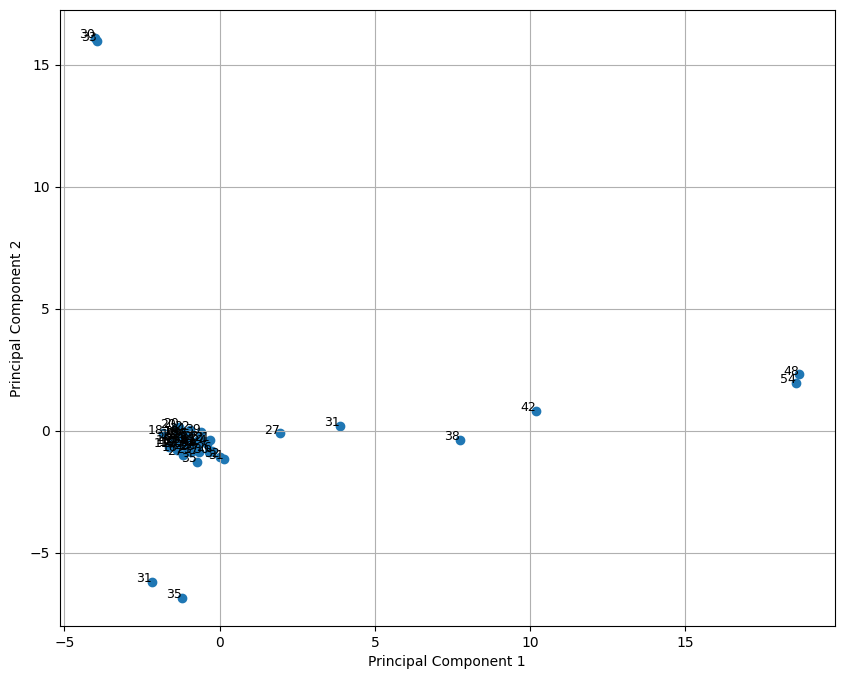

In [44]:
#We Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(df_genecount_pca[:, 0], df_genecount_pca[:, 1], cmap='viridis')
#We will now add the data labels (we can later replace the data labels with any feature)
for i, name in enumerate(df['Bioremediation potential']):  # assuming `df_numeric` has row indices as names
    plt.text(df_genecount_pca[i, 0], df_genecount_pca[i, 1], name, fontsize=9, ha='right')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

We can see that the strains positioned farest from the big group are the ones that have a higher bioremediation potential. This makes sense as the BP is the sum of the gene counts, and these gene counts are the only input that the model has received.
Seeing this PCA we could hypothesize that the source environment of the strains is an important factor that determinies the bioremeidation potential of Pseudomonas putida.

However, we will also label the data points depending on the pollution of the sites, as soil samples are the ones with more polluted samples.

<ipython-input-45-b9d97d24ec31>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_genecount_pca[:, 0], df_genecount_pca[:, 1], cmap='viridis')


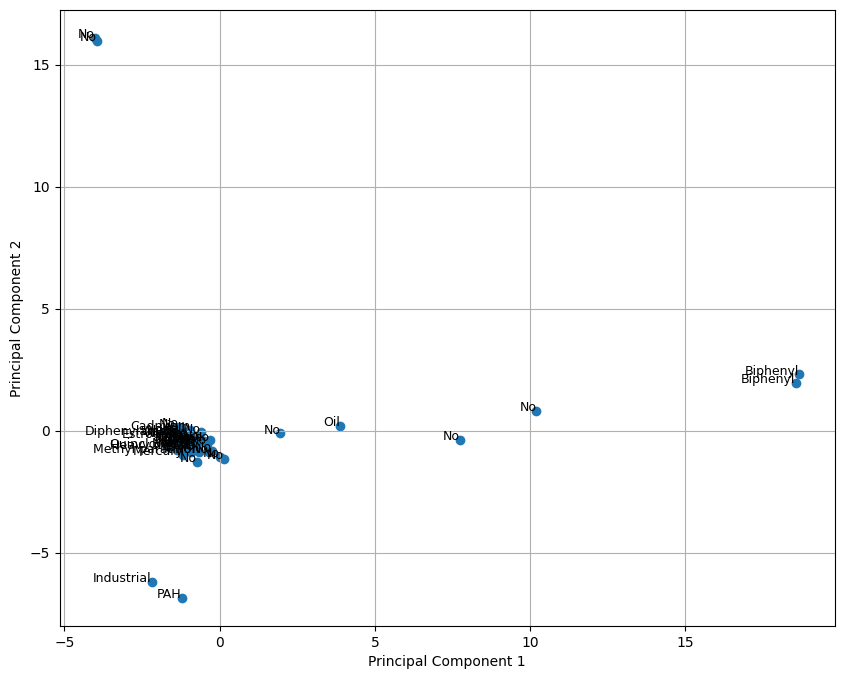

In [45]:
#We Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(df_genecount_pca[:, 0], df_genecount_pca[:, 1], cmap='viridis')
#We will now add the data labels (we can later replace the data labels with any feature)
for i, name in enumerate(df['Pollution']):  # assuming `df_numeric` has row indices as names
    plt.text(df_genecount_pca[i, 0], df_genecount_pca[i, 1], name, fontsize=9, ha='right')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

When we label the strains based on the poollution present in their sampling site, we see that some of the far away points seem to be distant from the group because of the pollution present.

For example, these two strains that we see were collected in a byphenil polluted soil, contain a whole operon of biphenyl degrading genes, that surely increased their bioremediation potential.

However, not all of the far away points represent strains collected from polluted sites, and not all the strains that we see grouped together were collected from non-polluted sites.

So we cannot assure that the pollution of the collection site is crucial to determine bioremediation potential, even if we know that it has an important effect on it.


## *PERMANOVA*

To see if our hypothesies are statistically fundamented, we performed a **PERMANOVA** analysis. We will use this statistical test to determine if grouping the PCA by source environment is significant.

This is, to see if the grouping of the strains by source environment when taking into account their gene counts has statistical relevance.



In [49]:
#Determine the groups for PERMANOVA analysis
groups = df['Isolation matrix'].tolist()

In [50]:
#Calculate a distance matrix from the PCA data (Euclidean distance)
distance_matrix = squareform(pdist(df_genecount_pca, metric = 'euclidean'))

In [51]:
#Convert distance matrix into skbio DistanceMatrix format
dist_matrix = DistanceMatrix(distance_matrix, ids=[f"Sample_{i}" for i in range(len(df_genecount_pca))])

In [53]:
#Run PERMANOVA
permanova_result = permanova(distance_matrix = dist_matrix, grouping = groups)

#Display PERMANOVA results
print('\nPERMANOVA Results:')
print(permanova_result)


PERMANOVA Results:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      59
number of groups                  4
test statistic             2.267631
p-value                       0.033
number of permutations          999
Name: PERMANOVA results, dtype: object


Seeing the results we can see that the test supports that grouping the strains by their source environment is significative.

However, we already saw that the strains collected from soil show a different pattern than the rest, so we performed a **Pairwise PERMANOVA**.
In this statistical test, all the source environment groups will be tested against each other.

In [55]:
#We will define a functoin to perform pairwise PERMANOVA
def pairwise_permanova(distance_matrix, groups, group_labels):
    """
    Perform pairwise PERMANOVA for all combinations of groups.

    Parameters:
    - distance_matrix: A skbio DistanceMatrix object.
    - groups: List of group labels for each sample.
    - group_labels: Unique group names.

    Returns:
    - results: A DataFrame summarizing pairwise PERMANOVA results.
    """
    results = []
    for group1, group2 in combinations(group_labels, 2):
        # Subset data for the two groups
        indices = [i for i, g in enumerate(groups) if g in [group1, group2]]
        sub_matrix = distance_matrix.filter([distance_matrix.ids[i] for i in indices])
        sub_groups = [groups[i] for i in indices]

        # Perform PERMANOVA
        result = permanova(distance_matrix=sub_matrix, grouping=sub_groups)
        print('for groups:', group1, group2)
        print(result)
    return pd.DataFrame(results)

In [57]:
#We prepare the data for pairwise analysis
group_labels = list(set(groups))
print('\nPairwise PERMANOVA Results: ')
pairwise_results = pairwise_permanova(dist_matrix, groups, group_labels)


Pairwise PERMANOVA Results: 
for groups: Clinical Water
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  2
test statistic             0.307819
p-value                       0.524
number of permutations          999
Name: PERMANOVA results, dtype: object
for groups: Clinical Rhizosphere
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  2
test statistic             0.776559
p-value                        0.78
number of permutations          999
Name: PERMANOVA results, dtype: object
for groups: Clinical Soil
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  2
test statistic             1.855167
p-value                       0.171
number of permutations          999
Name: PERMANOVA results, dtype: object
for groups:

We find that only some group comparisons involving soil strains showed significant differences. However, not all other groupings demonstrated statistical significance.

This is why we thought that a further analysis was needed, and we chose Machine Learning approach.


# **Supervised learning**

## *XGBoost model*

 To see which of the variables is more important in the determination of bioremediation potential, we tried to predict the bioremediation potential of some strains.

 For this we used the **XGBoost** model.
 The hyperparameters used were the following:
 - *n_estimators:*
 - *early_stopping rounds:*
 - *learning_rate:*

We set a high value of n_estimators, and to avoid overfitting, we also set early_stopping rounds that sill avoid unnecessary iterations. Also, we set a lower learning_rate than usual, in order to make sure we don't have any overfitting.

The model will have a lot of iterations to go through, but if the last 5 rounds do not have any improvement (early stopping), it will stop iterating.
Besides, the predictions from each component model will add less information each (lower learning rate).

We will perform cross validation in the model, as our dataset is quite small and could be prone to overfitting.

In [58]:
target = 'Bioremediation potential'
#Now we identify and separate numerical and categorical columns, as the model can't handle categorical data.
categorical_columns = ["Isolation matrix", "Specific isolation matrix",
                   "More specific", "Host", "Pollution", "Localization", "ST Cluster"]
numeric_columns = df.select_dtypes(include=np.number).columns.drop([target, "ST Cluster"])

We will encode the categorical data using One-Hot Encoding, as our categorical data is not hierarchical.

In [67]:
df_encoded = pd.get_dummies(df, columns=categorical_columns, dtype = 'int')
df_encoded.head()

,PobA,alkB,amoA,arsC,arsR1,bcsA,bcsB,BenR,bnzA,bphA1,bphA2,bphA3,bphA4,bphB,bphC,bphD,chR,copA,copA1,dmpK,dmpL,dmpM,dmpN,dmpO,dmpP,intl1,katA,merA,merB,merR,merT,mrdH,mreA,nahA1,nahA2,nahA3,nahA4,nahB,nahC,nahD,nahE,nahF,nirS,norB,oxyR,pcaG,pcaH,pcaR,rubA,sodA,srpA,srpB,srpC,srpR,srpS,tnpA,todA,todB,todC1,todC2,todD,todE,todF,todT,tolA,tolB,tolQ,tolR,ttgA,ttgB,ttgC,ttgD,ttgE,ttgF,ttgG,ttgH,ttgI,xylA,xylB,xylC,xylM,xylN,xylS,xylU,xylW,Bioremediation potential,Isolation matrix_Clinical,Isolation matrix_Rhizosphere,Isolation matrix_Soil,Isolation matrix_Water,Specific isolation matrix_Agricultural soil,Specific isolation matrix_Basin,Specific isolation matrix_Blood,Specific isolation matrix_Branch,Specific isolation matrix_Farmland,Specific isolation matrix_Fluid,Specific isolation matrix_Industrial,Specific isolation matrix_Lake,Specific isolation matrix_Rectal,Specific isolation matrix_Respiratory,Specific isolation matrix_River,Specific isolation matrix_Root,Specific isolation matrix_Sea,Specific isolation matrix_Seed,Specific isolation matrix_Skin,Specific isolation matrix_Soil,Specific isolation matrix_Urine,Specific isolation matrix_Wastewater,More specific_Agricultural soil,More specific_Avocado,More specific_Basin,More specific_Blood,More specific_Coal waste,More specific_Deep sea,More specific_Electronic wastes,More specific_Fluid,More specific_Ginseng,More specific_Grass,More specific_House,More specific_Industrial,More specific_Infection,More specific_Kiwi,More specific_Lake,More specific_Legume,More specific_Lesion,More specific_Lung,More specific_No,More specific_Oceanic epipelagic zone,More specific_Ornamental,More specific_Papernill,More specific_Pistachio,More specific_Potato,More specific_Pulp mill sludge,More specific_Ranch,More specific_Rectal,More specific_River,More specific_Sand,More specific_Sediment,More specific_Septic joint,More specific_Sewage sludge,More specific_Soil,More specific_Tobacco-rice,More specific_Tomato,More specific_Trachea,More specific_Vineyard,More specific_Walnuts,More specific_Wastewater,More specific_Wheat,More specific_Willow,Host_Human,Host_No,Host_Plant,Pollution_BPA,Pollution_Biphenyl,Pollution_Cadmium,Pollution_Diphenylamine,Pollution_Estrogen,Pollution_Heavy metal,Pollution_Industrial,Pollution_Lignine,Pollution_Mercury,Pollution_Methyl parathion,Pollution_No,Pollution_Oil,Pollution_PAH,Pollution_PCB,Pollution_Quinclorac,Pollution_Waste,Localization_Belgium,Localization_Brazil,Localization_Canada,Localization_Chile,Localization_China,Localization_Czech Republic,Localization_Finland,Localization_France,Localization_Greece,Localization_India,Localization_Japan,Localization_Mozambique,Localization_Netherlands,Localization_New zeland,Localization_Pacific ocean,Localization_Poland,Localization_Russia,Localization_South Korea,Localization_Spain,Localization_Thailand,Localization_USA,Localization_USa,Localization_Ukraine,ST Cluster_1,ST Cluster_2,ST Cluster_3,ST Cluster_4,ST Cluster_5,ST Cluster_6,ST Cluster_7,ST Cluster_8,ST Cluster_9,ST Cluster_10,ST Cluster_11,ST Cluster_12,ST Cluster_13,ST Cluster_14,ST Cluster_15,ST Cluster_16,ST Cluster_17,ST Cluster_18,ST Cluster_19
strain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12917,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,2,1,2,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,2,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
991_21,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,1,2,1,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,31,1,0

In [63]:
#We will now select the features
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

In [65]:
#We will now divide the features and the target into test and traininig sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.3, random_state=42)

In [98]:
#we will now define and run the model
xgb_model = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.85, eval_metric=mean_absolute_error, early_stopping_rounds=5)
xgb_model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_test_xgb, y_test_xgb)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test_xgb)
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(y_pred_xgb, y_test_xgb)))
print("Mean Squared Error : " + str(mean_squared_error(y_pred_xgb, y_test_xgb)))
print("Mean Absolute Percentage Error : " + str(metrics.mean_absolute_percentage_error(y_pred_xgb, y_test_xgb)))
print("R2 Score : " + str(metrics.r2_score(y_pred_xgb, y_test_xgb)))

Mean Absolute Error : 2.8893725872039795
Mean Squared Error : 12.58305549621582
Mean Absolute Percentage Error : 0.117146797478199
R2 Score : 0.8021976947784424




The comparison of these results with the results of an XGBoost model with cross validation could be interesting, and it is being revised at the moment.

## *SHAP analysis*

After we have the model prepared, we can see which are the most important features in the dataset that better explain the bioremediation potential of the strains.

For this, we will perform a **SHAP analysis**, that will explain the importance of each feature and how the values of each variable affect the bioremediation potential.

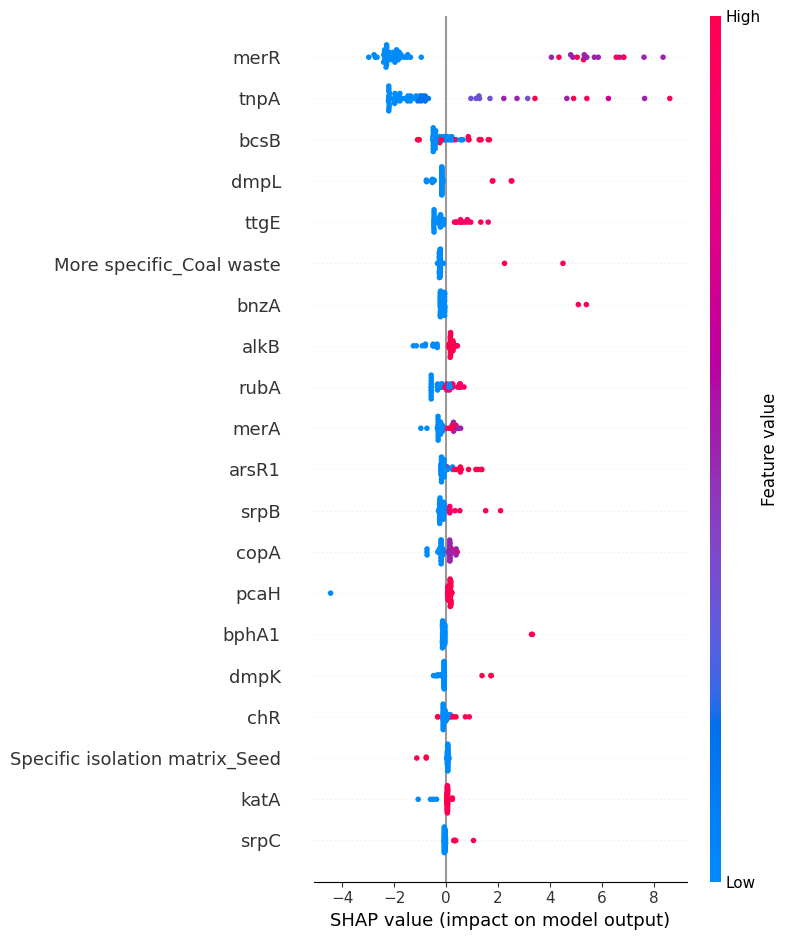

In [90]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

We can see in the graph that the most important variables are not the source environments of the strains but different genes. merR, tnpA, bcsB... we can see that the presence of these genes is indicative of a higher bioremediation potential.

This results demonstrate that the genomic component of P putida is relevant in the determination of bioremediation potential, and that these markers can be useful in the search of potentially useful strains for bioremediation.


